# Kinetic Synaptic Models

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/brainpy/brainpy/blob/master/docs_version2/tutorial_building/kinetic_synapse_models.ipynb)
[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/brainpy/brainpy/blob/master/docs_version2/tutorial_building/kinetic_synapse_models.ipynb)

In [1]:
import numpy as np
import brainpy as bp
import brainpy.math as bm

import matplotlib.pyplot as plt

The simplest kinetic model is a two-state scheme in which receptors can be either closed, C, or open, O, and the transition between states depends on transmitter concentration, [T], in the synaptic cleft. For a pool of receptors, states C and O can range from 0 to 1, and describe the fraction of receptors in the closed and open states, respectively.

## AMPA synapse model

AMPA receptor is an ionotropic receptor, which is an ion channel. When it is bound by neurotransmitters, it will immediately open the ion channel, causing the change of membrane potential of postsynaptic neurons.

A classical model is to use the Markov process to model ion channel switch. Here $s$ represents the probability of channel opening, $1-s$ represents the probability of ion channel closing, and $\alpha$ and $\beta$ are the transition probability. Because neurotransmitters can open ion channels, the transfer probability from $1-s$ to $s$ is affected by the concentration of neurotransmitters. We denote the concentration of neurotransmitters as [T] and get the following Markov process.

![](../_static/synapse_markov.png)

We obtained the following formula when describing the process by a differential equation.

$$
\frac {ds}{dt} = \alpha [T] (1-s) - \beta s
$$

Where $\alpha [T]$ denotes the transition probability from state $(1-s)$ to state $(s)$; and $\beta$ represents the transition probability of the other direction. $\alpha=0.98$ is the binding constant. $\beta=.18$ is the unbinding constant. $T=.5\, mM$ is the neurotransmitter concentration, and has the duration of 0.5 ms.

$$
I=\bar{g}s(V-E)
$$

where $\bar{g} = 0.42$ $\mu ho(\mu S)$ is the maximum conductance. $E=0.$ mV is a reverse potential, which can determine whether the direction of $I$ is inhibition or excitation. For example, when the resting potential is about -65, subtracting a lower $E$, such as -75, will become positive, thus will change the direction of the current in the formula and produce the suppression current. The $E$ value of excitatory synapses is relatively high, such as 0.

In [2]:
class AMPA(bp.Projection):
    def __init__(self, pre, post, delay, prob, g_max, E=0.):
        super().__init__()
        self.proj = bp.dyn.ProjAlignPreMg2(
          pre=pre, 
          delay=delay, 
          syn=bp.dyn.AMPA.desc(pre.num, alpha=0.98, beta=0.18, T=0.5, T_dur=0.5),
          comm=bp.dnn.CSRLinear(bp.conn.FixedProb(prob, pre=pre.num, post=post.num), g_max),
          out=bp.dyn.COBA(E=E),
          post=post, 
        )

In [3]:
class SimpleNet(bp.DynSysGroup):
  def __init__(self, syn_cls):
    super().__init__()
    self.pre = bp.dyn.SpikeTimeGroup(1, indices=(0, 0, 0, 0), times=(10., 30., 50., 70.))
    self.post = bp.dyn.LifRef(1, V_rest=-60., V_th=-50., V_reset=-60., tau=20., tau_ref=5.,
                              V_initializer=bp.init.Constant(-60.))
    self.syn = syn_cls(self.pre, self.post, delay=None, prob=1., g_max=1.)
    
  def update(self):
    self.pre()
    self.syn()
    self.post()
    
    # monitor the following variables
    conductance = self.syn.proj.refs['syn'].g
    current = self.post.sum_inputs(self.post.V)
    return conductance, current, self.post.V

In [4]:
def run_a_net(net, duration=100):
  indices = np.arange(int(duration/bm.get_dt()))  # duration ms
  conductances, currents, potentials = bm.for_loop(net.step_run, indices, progress_bar=True)
  ts = indices * bm.get_dt()
  
  # --- similar to: 
  # runner = bp.DSRunner(net)
  # conductances, currents, potentials = runner.run(100.)
  
  fig, gs = bp.visualize.get_figure(1, 3, 3.5, 4)
  fig.add_subplot(gs[0, 0])
  plt.plot(ts, conductances)
  plt.title('Syn conductance')
  fig.add_subplot(gs[0, 1])
  plt.plot(ts, currents)
  plt.title('Syn current')
  fig.add_subplot(gs[0, 2])
  plt.plot(ts, potentials)
  plt.title('Post V')
  plt.show()

D:\codes\projects\BrainPy\brainpy\version2\mixin.py:399: UserWarning: Please use ".sum_current_inputs()" instead. ".sum_inputs()" will be removed.
  warnings.warn('Please use ".sum_current_inputs()" instead. ".sum_inputs()" will be removed.', UserWarning)


  0%|          | 0/1000 [00:00<?, ?it/s]

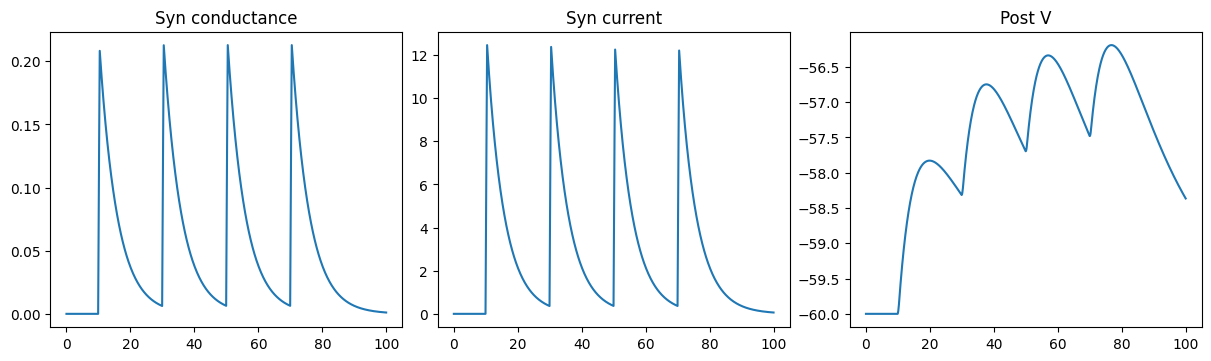

In [5]:
run_a_net(SimpleNet(syn_cls=AMPA))

## $GABA_A$ synapse model

GABAA synapse has the same equation with the AMPA synapse, but with the difference of:

-  Reversal potential of synapse $E=-80.$ mV 
- Activating rate constant $\alpha=0.53$
- De-activating rate constant $\beta=0.18$
- Transmitter concentration $[T]=1\,\mu ho(\mu S)$ when synapse is triggered by a pre-synaptic spike, with the duration of 1. ms. 

In [6]:
class GABAa(bp.Projection):
    def __init__(self, pre, post, delay, prob, g_max, E=-80.):
        super().__init__()
        self.proj = bp.dyn.ProjAlignPreMg2(
          pre=pre, 
          delay=delay, 
          syn=bp.dyn.GABAa.desc(pre.num, alpha=0.53, beta=0.18, T=1.0, T_dur=1.0),
          comm=bp.dnn.CSRLinear(bp.conn.FixedProb(prob, pre=pre.num, post=post.num), g_max),
          out=bp.dyn.COBA(E=E),
          post=post, 
        )

D:\codes\projects\BrainPy\brainpy\version2\mixin.py:399: UserWarning: Please use ".sum_current_inputs()" instead. ".sum_inputs()" will be removed.
  warnings.warn('Please use ".sum_current_inputs()" instead. ".sum_inputs()" will be removed.', UserWarning)


  0%|          | 0/1000 [00:00<?, ?it/s]

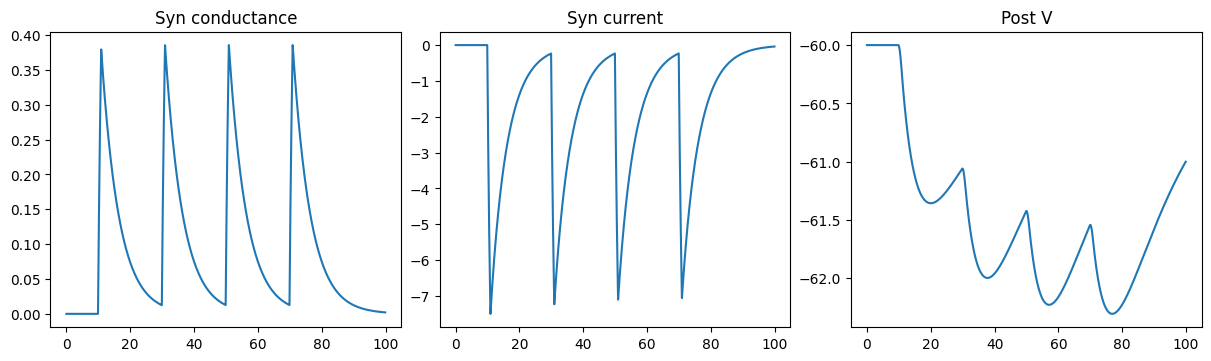

In [7]:
run_a_net(SimpleNet(syn_cls=GABAa))

## NMDA synapse model

The NMDA receptor is a glutamate receptor and ion channel found in neurons. The NMDA receptor is one of three types of ionotropic glutamate receptors, the other two being AMPA and kainate receptors.


The NMDA receptor mediated conductance depends on the postsynaptic voltage. The voltage dependence is due to the blocking of the pore of the NMDA receptor from the outside by a positively charged magnesium ion. The channel is nearly completely blocked at resting potential, but the magnesium block is relieved if the cell is depolarized. The fraction of channels $B(V)$ that are not blocked by magnesium can be fitted to

$$
B(V) = {1 \over 1 + \exp(-0.062V) [Mg^{2+}]_o/3.57}
$$

Here, $[{Mg}^{2+}]_{o}$ is the extracellular magnesium concentration, usually 1 mM. Thus, the channel acts as a “coincidence detector” and only once both of these conditions are met, the channel opens and it allows positively charged ions (cations) to flow through the cell membrane. 

If we make the approximation that the magnesium block changes instantaneously with voltage and is independent of the gating of the channel, the net NMDA receptor-mediated synaptic current is given by

$$
I=\bar{g}sB(V)(V-E)
$$

where $V(t)$ is the post-synaptic neuron potential, $E$ is the reversal potential.

In [8]:
class NMDA(bp.Projection):
    def __init__(self, pre, post, delay, prob, g_max, E=0.0):
        super().__init__()
        self.proj = bp.dyn.ProjAlignPreMg2(
          pre=pre, 
          delay=delay, 
          syn=bp.dyn.NMDA.desc(pre.num, a=0.5, tau_decay=100., tau_rise=2.), 
          comm=bp.dnn.CSRLinear(bp.conn.FixedProb(prob, pre=pre.num, post=post.num), g_max), 
          out=bp.dyn.MgBlock(E=E), 
          post=post, 
        )

D:\codes\projects\BrainPy\brainpy\version2\mixin.py:399: UserWarning: Please use ".sum_current_inputs()" instead. ".sum_inputs()" will be removed.
  warnings.warn('Please use ".sum_current_inputs()" instead. ".sum_inputs()" will be removed.', UserWarning)


  0%|          | 0/1000 [00:00<?, ?it/s]

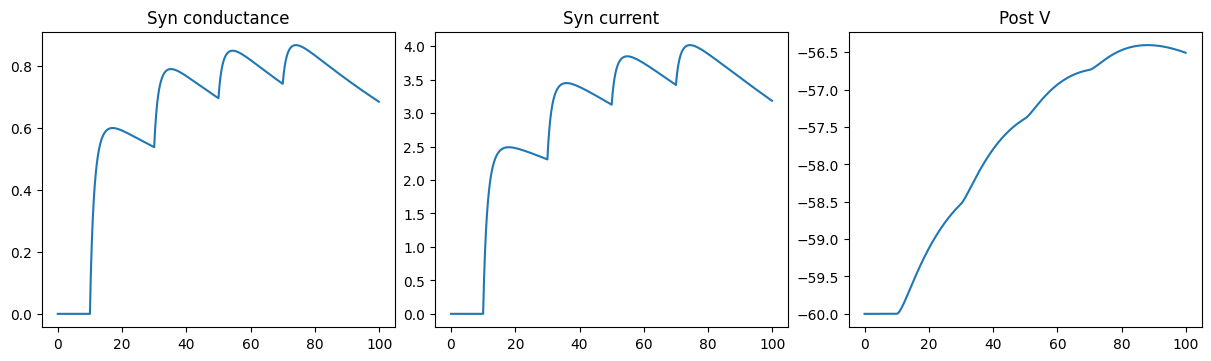

In [9]:
run_a_net(SimpleNet(NMDA))

## Kinetic synapse models are more realistic

Kinetic synapse can prevent the explosion of the synaptic dynamics. 

In [10]:
class SimpleNet5(bp.DynSysGroup):
  def __init__(self, freqs=10.):
    super().__init__()
    
    self.pre = bp.dyn.PoissonGroup(1, freqs=freqs)
    self.post = bp.dyn.LifRef(1,  V_rest=-60., V_th=-50., V_reset=-60., tau=20., tau_ref=5.,
                              V_initializer=bp.init.Constant(-60.))
    self.syn = NMDA(self.pre, self.post, delay=None, prob=1., g_max=1., E=0.)
    
  def update(self):
    self.pre()
    self.syn()
    self.post()
    
    # monitor the following variables
    return self.syn.proj.refs['syn'].g, self.post.V

In [11]:
def compare_freqs(freqs):
  fig, _ = bp.visualize.get_figure(1, 1, 4.5, 6.)
  for freq in freqs:
      net = SimpleNet5(freqs=freq)
      indices = np.arange(1000)  # 100 ms
      conductances, potentials = bm.for_loop(net.step_run, indices, progress_bar=True)
      ts = indices * bm.get_dt()
      plt.plot(ts, conductances, label=f'{freq} Hz')
  plt.legend()
  plt.ylabel('g')
  plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

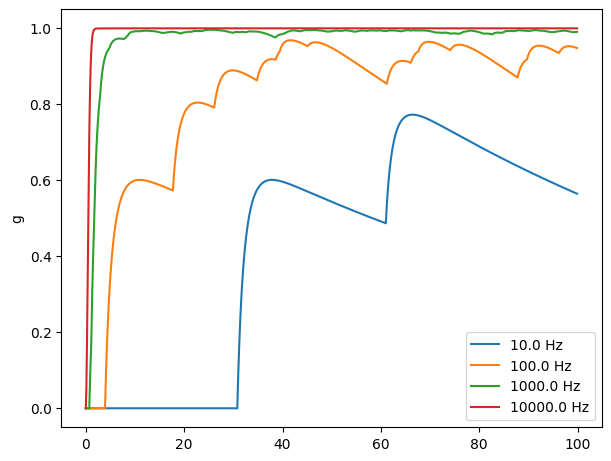

In [12]:
compare_freqs([10., 100., 1000., 10000.])